In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
import pickle

from ema_workbench.util import utilities
from ema_workbench.analysis import prim, cart

D:\EPA\Advanced_simulation\EPA1361_Model-based_Decision-making\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Open Exploration

- No policy (everything 0)
- Latin hypercube of scenarios (10.000 scenarios)
- Result: choose 20 to 50 scenarios

First, the model is initialized, using problem formulation 5.

In [3]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)

Then, a reference policy is initialized, in which all policy variables are set to 0.

In [4]:
# set reference policy as all 0's
reference = Policy("0_policy", **{l.name: 0 for l in dike_model.levers})

if we decide to include the timestep:this saves the seperate timesteps to a csv.

In [5]:
# n_scenarios = 10000
#
# # running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
# with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)
#
# utilities.save_results(results,r'generated_datasets\50ScenariosBaseCase_separate.csv')

In [6]:
# test = pd.read_csv(r'generated_datasets\50ScenariosBaseCase_separate.csv', compression='gzip',on_bad_lines='skip').dropna()
# test

However, this is the one that we will be using: combining the timesteps into a single value. The model is run, and results are saved

In [7]:
n_scenarios = 10_000

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [16:06<00:00, 10.34it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
# as we do not plan on using the timeseries data, we add them up into a single value. This is then saved to a pickle file for later use

df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    df[k]=test_list

with open(r'generated_datasets\open_exploration_base_policy.pkl','wb') as pickle_file:
    pickle.dump(df, pickle_file)

The data is then loaded into a dataframe. The cost of death variables are calculated and added to the data.

In [9]:
outcomes = pd.read_pickle(r'generated_datasets\open_exploration_base_policy.pkl')

In [10]:
# calculate the cost of death so every column has the same unit (€)
outcomes["A.1_Deaths_Cost"]=outcomes["A.1_Expected Number of Deaths"]*2_700_000
outcomes["A.2_Deaths_Cost"]=outcomes["A.2_Expected Number of Deaths"]*2_700_000
outcomes["A.3_Deaths_Cost"]=outcomes["A.3_Expected Number of Deaths"]*2_700_000
outcomes["A.4_Deaths_Cost"]=outcomes["A.4_Expected Number of Deaths"]*2_700_000
outcomes["A.5_Deaths_Cost"]=outcomes["A.5_Expected Number of Deaths"]*2_700_000

to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]

outcomes.drop(to_drop, axis=1, inplace=True)
outcomes['total_cost[€]']= outcomes.sum(axis=1)

In [11]:
#input variables and output combined into a single dataframe
results = experiments.join(outcomes)
results.drop(columns=['policy','model','scenario'], inplace=True)

In [12]:
results


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Expected Annual Damage,A.5_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs,A.1_Deaths_Cost,A.2_Deaths_Cost,A.3_Deaths_Cost,A.4_Deaths_Cost,A.5_Deaths_Cost,total_cost[€]
0,131,238.967815,1.5,0.596084,37.245806,1.0,0.045692,73.729667,1.5,0.247648,...,0.000000e+00,0,0.0,0.0,2.030069e+05,2.247209e+06,2.850182e+06,0.000000,0.000000,1.345551e+09
1,51,114.531312,10.0,0.339979,197.097296,1.5,0.823865,169.426958,1.0,0.151486,...,0.000000e+00,0,0.0,0.0,3.508196e+06,0.000000e+00,6.774987e+06,0.000000,0.000000,3.376485e+09
2,7,301.817232,1.5,0.083777,286.332683,1.0,0.866057,169.753845,10.0,0.078429,...,0.000000e+00,0,0.0,0.0,4.989729e+06,0.000000e+00,6.074189e+05,0.000000,0.000000,3.140574e+09
3,106,288.535849,1.5,0.634263,275.964437,1.5,0.664538,55.283158,1.5,0.026015,...,0.000000e+00,0,0.0,0.0,2.003315e+05,7.636609e+04,9.131906e+06,0.000000,0.000000,2.283128e+09
4,3,230.938194,10.0,0.818728,148.535107,1.5,0.702174,299.577721,1.0,0.327873,...,0.000000e+00,0,0.0,0.0,8.156367e+03,7.902036e+04,3.028860e+06,0.000000,0.000000,6.397127e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,68,123.248401,1.5,0.066357,110.408643,10.0,0.470949,78.171458,1.5,0.370214,...,0.000000e+00,0,0.0,0.0,5.003252e+06,2.070736e+04,4.652919e+05,21612.215223,0.000000,2.480135e+09
9996,106,53.297210,1.0,0.313684,68.609158,1.0,0.526750,268.789511,1.0,0.892635,...,0.000000e+00,0,0.0,0.0,4.972348e+06,7.309829e+04,0.000000e+00,56619.719490,0.000000,2.919973e+09
9997,128,131.073152,10.0,0.029127,320.537101,10.0,0.911369,94.919445,1.0,0.896855,...,0.000000e+00,0,0.0,0.0,4.928092e+06,0.000000e+00,0.000000e+00,17734.995229,0.000000,2.643889e+09
9998,85,156.284627,10.0,0.984734,83.241332,1.0,0.729384,306.306525,10.0,0.697223,...,2.064088e+08,0,0.0,0.0,0.000000e+00,7.756647e+04,2.753483e+05,2055.323211,410235.074004,3.140561e+08


In [13]:
total_values = pd.DataFrame()
total_values['Expected Annual Damage'] = results['A.1_Expected Annual Damage'] + \
                                         results['A.2_Expected Annual Damage'] + \
                                         results['A.3_Expected Annual Damage'] + \
                                         results['A.4_Expected Annual Damage'] + \
                                         results['A.5_Expected Annual Damage']

total_values['Dike Investment Costs'] = results['A.1_Dike Investment Costs'] + \
                                        results['A.2_Dike Investment Costs'] + \
                                        results['A.3_Dike Investment Costs'] + \
                                        results['A.4_Dike Investment Costs'] + \
                                        results['A.5_Dike Investment Costs']

total_values['Deaths_Cost'] = results['A.1_Deaths_Cost'] + \
                              results['A.2_Deaths_Cost'] + \
                              results['A.3_Deaths_Cost'] + \
                              results['A.4_Deaths_Cost'] + \
                              results['A.5_Deaths_Cost']

# Visualizations / conclusions?

Finding the worst case scenarios top 20, difined by highest total costs

In [14]:
n_scenarios_of_interest = 20

results_of_interest = results.sort_values(by='total_cost[€]', ascending=False).head(n_scenarios_of_interest)

with open(r'generated_datasets\open_exploration_base_policy_worst_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

### Scenario Discovery
- Boxplots
- PRIM
- Scatterplots
- CART-tree

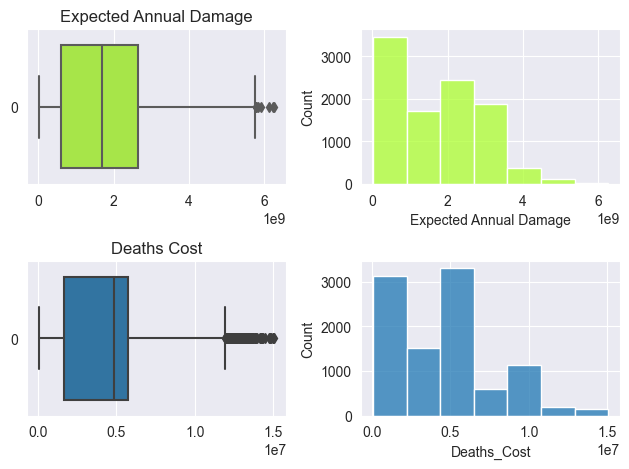

In [15]:
fig, axes = plt.subplots(2,2)

# Expected Annual Damage boxplot
sns.boxplot(
    ax=axes[0,0],
    data=total_values['Expected Annual Damage'],
    orient='h',
    color='greenyellow',
).set(title='Expected Annual Damage')

# Deaths_Cost boxplot
sns.boxplot(
    ax=axes[1,0],
    data=total_values['Deaths_Cost'],
    orient='h',
).set(title='Deaths Cost')

# Expected Annual Damage histogram
sns.histplot(
    ax=axes[0,1],
    data=total_values['Expected Annual Damage'],
    bins=7,
    color='greenyellow',
)

# Deaths_Cost histogram
sns.histplot(
    ax=axes[1,1],
    data=total_values['Deaths_Cost'],
    bins=7,
)

plt.tight_layout()

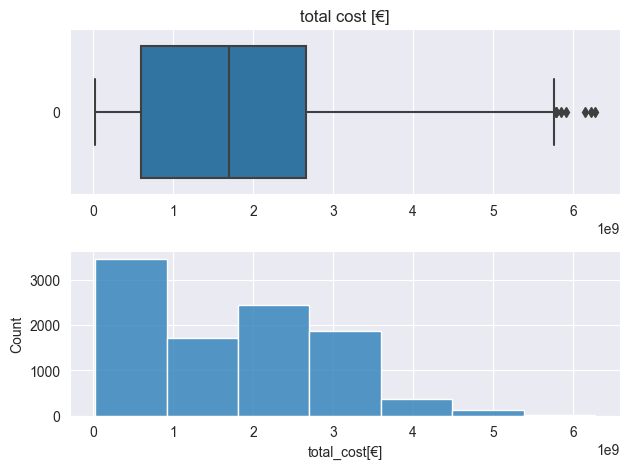

In [16]:
fig, axes = plt.subplots(2)

sns.boxplot(
    ax=axes[0],
    data=results['total_cost[€]'],
    orient='h',
).set(title='total cost [€]')

sns.histplot(
    ax=axes[1],
    data=results['total_cost[€]'],
    bins=7,
)

plt.tight_layout()

Eventueel nog plots per dikering

### DEATH ANALYSIS, SAME CAN BE DONE FOR OTHER VARIABLES

In [17]:
x = results.iloc[:,:19]  # Only take the uncertainties

y_death_cost = total_values['Deaths_Cost'].values
y_death_cost = y_death_cost > np.percentile(y_death_cost, 75)

[MainProcess/INFO] 10000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1153, coverage: 0.4612, density: 1.0 restricted_dimensions: 3


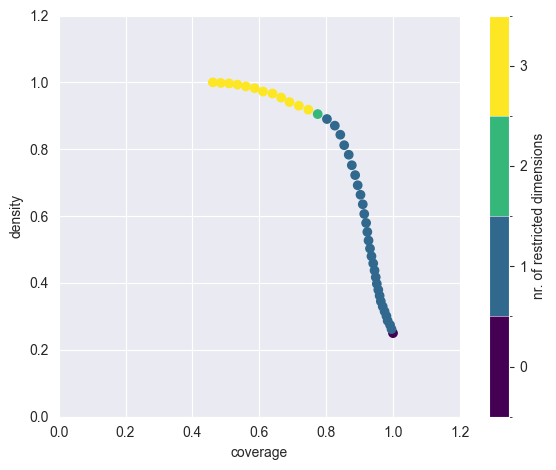

In [24]:
prim_alg = prim.Prim(x,
                     y_death_cost,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
box = prim_alg.find_box()

box.show_tradeoff()
plt.tight_layout()

coverage     0.4612
density      1.0000
id          42.0000
mass         0.1153
mean         1.0000
res_dim      3.0000
Name: 42, dtype: float64

             box 42                                 
                min       max      qp value qp value
A.3_pfail  0.000011  0.183019           NaN      0.0
A.1_pfail  0.319100  0.999950  8.940011e-34      NaN
A.2_pfail  0.105689  0.999914  2.050394e-09      NaN



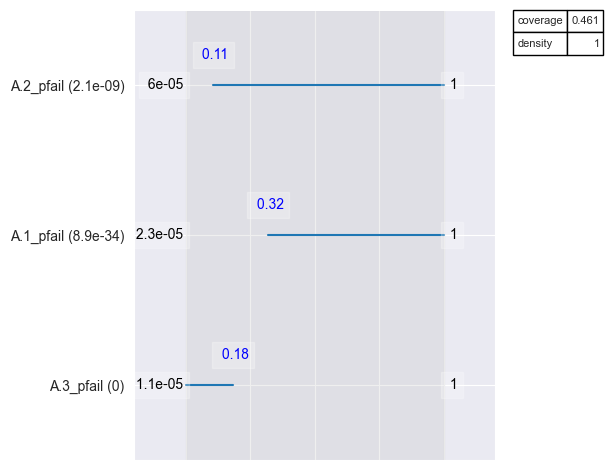

In [25]:
box.inspect()
box.inspect(style='graph')
plt.tight_layout()

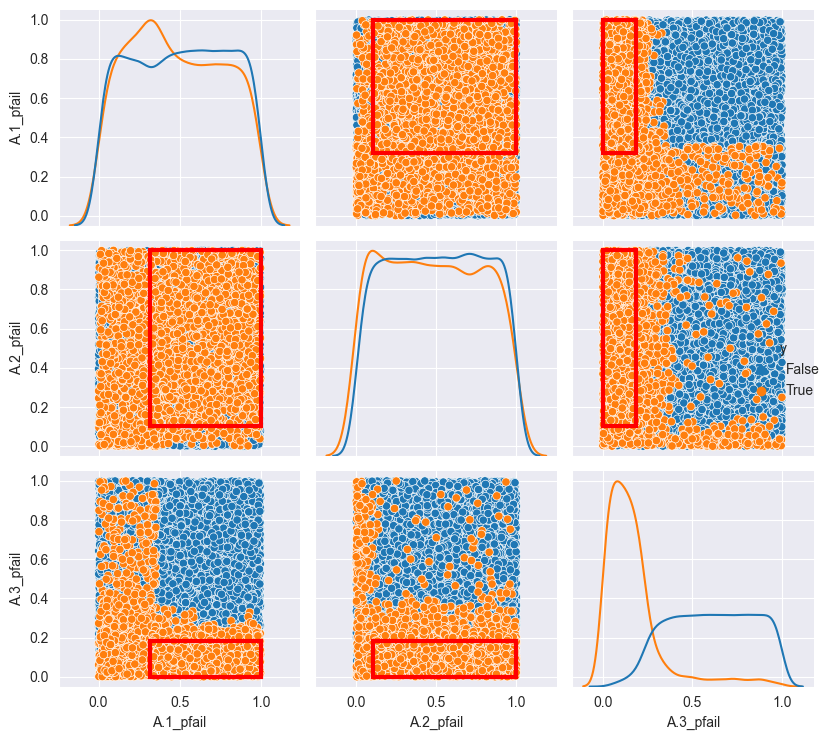

In [26]:
box.select(-1)
box.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()

### CART

In [29]:
cart_plot = cart.CART(x, y_death_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

FileNotFoundError: [WinError 2] "dot" not found in path.